# PyKOALA Data Reduction Sequence

This notebook contains the basic reduction steps that can be done with pyKOALA for the KOALA instrument.

In [54]:
from matplotlib import pyplot as plt
import numpy as np
from koala import __version__
import warnings

# You may want to comment the following line
warnings.filterwarnings("ignore")
print("pyKOALA version: ", __version__)

pyKOALA version:  0.1.1


First, let's import a basic module to handle the RSS data:

In [7]:
from koala.koala_ifu import koala_rss

The koala_rss is a *DataContainer* that will be used to store the RSS data and track all the changes applied to it.

Now let's load some data that we have partially reduced with 2dfdr. The target will be the spectrophotometric standard star HR7596:

In [16]:
# List of RSS objects
std_star_rss = []
aaomega_arms = {'blue': 1, 'red': 2}
# Choose which arm of the spectrograph is going to be used
arm = 'blue'

for i in [23, 24, 25]:
    filename = f"data/07sep{aaomega_arms[arm]}00{i}red.fits"
    rss = koala_rss(filename)
    print(f"File {filename} corresponds to object {rss.header['OBJECT']}")
    std_star_rss.append(rss)

File data/07sep10023red.fits corresponds to object HR 7596
File data/07sep10024red.fits corresponds to object HR 7596 3S
File data/07sep10025red.fits corresponds to object HR 7596 3W


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]


Now let us start applying some corrections to the data!

In this tutorial, we will consider the following corrections:
- Instrumental throughput
- Atmospheric extinction
- Telluric absorption
- Sky emission

Some of these corrections might not be relevant at a particular wavelength regime. For example, the blue arm of the AAOMega spectrograph 3600-5000 A is not affected by the telluric absorption.

## Instrumental throughput

In [55]:
from koala.corrections.throughput import Throughput
from koala.plotting.qc_plot import qc_throughput

The throughput correction accounts for the differences in the efficiency of each fibre in the instrument. This effect also depends on the wavelength that we are using.

In pyKOALA (at least version <= 0.1.1) this can be computed from a set of input rss files that correspond to flat exposures as follows

In [56]:
Throughput.create_throughput_from_flat?

In [57]:
flat_rss = [koala_rss(f"data/07sep{aaomega_arms[arm]}00{flat}red.fits") for flat in [11, 12, 13, 14]]
throughput, throughput_std = Throughput.create_throughput_from_flat(flat_rss, clear_nan=True)

We can assess the quality of our resulting throughput correction by using the built-in quality control plotting functions

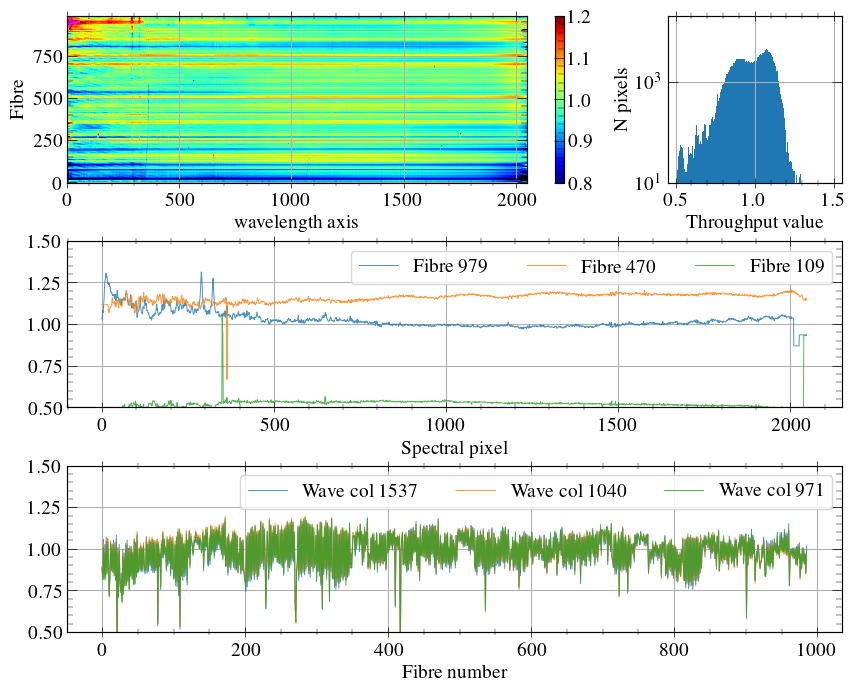

In [58]:
throughput_fig = qc_throughput(throughput)
plt.show(throughput_fig)

Now let's apply this correction to out standard star RSS. Like any correction in pyKOALA, there's an especial function to apply this correction:

In [65]:
throughput_corr = Throughput()
for i in range(len(std_star_rss)):
    std_star_rss[i] = throughput_corr.apply(throughput, std_star_rss[i])

Each correction is recorded within the `log` attribute:

In [66]:
for rss in std_star_rss:
    print(rss.log)

{'read': {'comment': '- RSS read from  07sep10023red.fits', 'index': None}, 'mask from file': {'comment': None, 'index': 0}, 'blue edge': {'comment': None, 'index': 1}, 'red edge': {'comment': None, 'index': 2}, 'cosmic': {'comment': None, 'index': 3}, 'extreme negative': {'comment': None, 'index': 4}, 'wavelength fix': {'comment': None, 'index': None, 'sol': []}, 'ThroughputCorrection': '2D throughput applied'}
{'read': {'comment': '- RSS read from  07sep10024red.fits', 'index': None}, 'mask from file': {'comment': None, 'index': 0}, 'blue edge': {'comment': None, 'index': 1}, 'red edge': {'comment': None, 'index': 2}, 'cosmic': {'comment': None, 'index': 3}, 'extreme negative': {'comment': None, 'index': 4}, 'wavelength fix': {'comment': None, 'index': None, 'sol': []}, 'ThroughputCorrection': '2D throughput applied'}
{'read': {'comment': '- RSS read from  07sep10025red.fits', 'index': None}, 'mask from file': {'comment': None, 'index': 0}, 'blue edge': {'comment': None, 'index': 1},